In [2]:
from utils.data_acquisition import get_players, get_matches, get_players_perfomance, get_next_match

## Generating player list ranked by position

In [3]:
players = get_players()

In [4]:
positions = players['position'].unique()

In [5]:
players_ranked = players.copy() 
players_ranked['rank'] = None

for position in positions:
    rank = players_ranked[players_ranked['position'] == position].id.rank(method='min')
    rank = rank - 1
    players_ranked.iloc[rank.index,-1] = rank

columns_sorted = ["rank", "nickname", "id", "position", "price", "team", "status"]
players_ranked = players_ranked[columns_sorted].drop_duplicates().sort_values('rank', ignore_index=True)

In [6]:
players_ranked.head(10)

,rank,nickname,id,position,price,team,status
0,0.0,Renato Augusto,38398,mei,7.78,FLU,Nulo
1,0.0,Thiago Heleno,38394,zag,6.53,CAP,Provável
2,0.0,Rafinha,38144,lat,7.00,SAO,Nulo
3,0.0,Renato Gaúcho,41929,tec,9.28,GRE,Provável
4,0.0,Vagner Love,38959,ata,4.76,ACG,Dúvida
5,0.0,Fábio,37656,gol,9.24,FLU,Provável
6,1.0,Cuca,42411,tec,11.57,CAP,Provável
7,1.0,Hulk,39148,ata,14.21,CAM,Provável
8,1.0,Marcelo,38402,lat,10.22,FLU,Provável
9,1.0,Cássio,42234,gol,11.40,CRU,Nulo


## Matches

In [7]:
matches = get_matches()

In [8]:
matches["home_score_norm"] = matches["home_score"]/matches["home_score"].max()
matches["away_score_norm"] = matches["away_score"]/matches["away_score"].max()

In [9]:
matches.shape

(60, 8)

In [10]:
matches.head()

,date,home_team,away_team,home_score,away_score,round,home_score_norm,away_score_norm
0,2024-04-13 18:30:00,INT,BAH,2.0,1.0,1,0.4,0.25
1,2024-04-13 18:30:00,CRI,JUV,1.0,1.0,1,0.2,0.25
2,2024-04-13 21:00:00,FLU,BGT,2.0,2.0,1,0.4,0.50
3,2024-04-13 21:00:00,SAO,FOR,1.0,2.0,1,0.2,0.50
4,2024-04-14 16:00:00,VAS,GRE,2.0,1.0,1,0.4,0.25


In [11]:
matches.iloc[-1]

date               2024-06-09 16:00:00
home_team                          CRI
away_team                          CUI
home_score                         NaN
away_score                         NaN
round                                6
home_score_norm                    NaN
away_score_norm                    NaN
Name: 59, dtype: object

Remark: RS teams didn't player last rounds

In [12]:
matches = matches.dropna().reset_index()

In [13]:
matches.shape

(52, 9)

### Players performance

In [14]:
players_performance = get_players_perfomance()

In [15]:
players_performance = players_performance.drop(
    ["price", "nickname", "position", "team"], axis=1)

In [16]:
players_performance.head()

,id,points,round
0,100079,2.6,1
1,100084,1.4,1
2,100085,5.0,1
3,100652,1.3,1
4,100846,-1.5,1


Joining the above table with the players table, which contains the ranks

In [17]:
players_performance = players_performance.set_index("id").join(players_ranked.set_index("id"))

In [18]:
players_performance.head()

,points,round,rank,nickname,position,price,team,status
id,,,,,,,,
100079,2.6,1,94.0,Zaracho,mei,8.03,CAM,Provável
100084,1.4,1,95.0,Igor Gomes,mei,5.43,CAM,Nulo
100085,5.0,1,96.0,Pedro Augusto,mei,3.75,FOR,Provável
100652,1.3,1,72.0,Yuri Alberto,ata,5.73,COR,Provável
100846,-1.5,1,49.0,Lucas Esteves,lat,2.66,VIT,Nulo


**Remark**: The price column here can lead to confusion. This price was get from the market database. So, it is the current price of the player in the market.
For this reason, I will rename the column: 

In [19]:
players_performance = players_performance.rename(columns={"price": "current_price"})

In [20]:
players_performance.columns

Index(['points', 'round', 'rank', 'nickname', 'position', 'current_price',
       'team', 'status'],
      dtype='object')

In [21]:
players_performance.shape

(1717, 8)

Removing player that are not available in the market

In [22]:
players_performance.drop(
    players_performance[players_performance['rank'].isnull()].index,
    inplace=True)

players_performance['rank'] = players_performance['rank'].astype(int)

In [23]:
players_performance.head()

,points,round,rank,nickname,position,current_price,team,status
id,,,,,,,,
100079,2.6,1,94,Zaracho,mei,8.03,CAM,Provável
100084,1.4,1,95,Igor Gomes,mei,5.43,CAM,Nulo
100085,5.0,1,96,Pedro Augusto,mei,3.75,FOR,Provável
100652,1.3,1,72,Yuri Alberto,ata,5.73,COR,Provável
100846,-1.5,1,49,Lucas Esteves,lat,2.66,VIT,Nulo


In [24]:
players_performance.shape

(1688, 8)

## Transition matrix M between the states
Until here, it is not clear for me yet what the states in this matrix means

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from typing import Literal, Callable, Tuple
from numpy._typing import NDArray, ArrayLike

In [26]:
def normalize_transition_matrix(m: NDArray) -> NDArray:
    """."""
    M_norm = m.copy()
    M_norm = M_norm / np.sum(M_norm, axis=1)[:, None] # Normalizing the rows.
    M_norm = np.nan_to_num(M_norm, nan=1/M_norm.shape[0])  # Replacing no info rows with equally distributed probability
    return M_norm

In [27]:
def forward(home_goals: int, away_goals: int) -> Tuple[int, int]:
    return home_goals, away_goals

def defender(home_goals: int, away_goals: int):
    home_extra_score, away_extra_score = 1, 1
    if away_goals:
        home_extra_score =- 1
    if home_goals:
        away_extra_score = -1
    return home_extra_score, away_extra_score

def midfilder(home_goals: int, away_goals: int) -> Tuple[int, int]:
    forward_h, forward_a = forward(home_goals, away_goals)
    defender_h, defender_a = defender(home_goals, away_goals)
    return forward_h + defender_h, forward_a + defender_a

def manager(*args) -> Tuple[int, int]:
    return 0,0

In [28]:
def generate_m_matrix(
        position: Literal["ata", "mei", "zag", "tec"], 
        extra_function: Callable[[int, int], Tuple[int, int]]
) -> NDArray:
    """."""
    players_performance_position = players_performance[
        players_performance["position"] == position
        ].copy()

    n_players = len(players_ranked[players_ranked["position"] == position])
    M = np.zeros([n_players, n_players])

    # The match are labeled from 0 to len(matches)
    for match in range(len(matches)):
        # Selecting all players that played in the round where the match ocurred
        df_round = players_performance_position[
            players_performance_position["round"] == matches["round"][match]
        ]
        # Selecting the players that played in the given match
        players_home = df_round[df_round["team"] == matches["home_team"][match]]
        players_away = df_round[df_round["team"] == matches["away_team"][match]]

        for p_home in range(len(players_home)):
            for p_away in range(len(players_away)):
                score_home, score_away = 0,0
            
                points_p_home = players_home["points"].iloc[p_home]
                points_p_away = players_away["points"].iloc[p_away]

                sum = points_p_home + points_p_away
                if sum != 0:
                    score_home = points_p_home/sum
                    score_away = points_p_away/sum
                
                # Selecting the coordinates of each player in the matrix
                p1 = players_home["rank"].iloc[p_home]
                p2 = players_away["rank"].iloc[p_away]

                home_extra_score, away_extra_score = extra_function(
                    matches['home_score_norm'][match],
                    matches['away_score_norm'][match]
                )
                home_extra_score, away_extra_score = 0,0

                M[p1,p1] = M[p1,p1] + home_extra_score + score_home
                M[p1,p2] = M[p1,p2] + away_extra_score + score_away
                M[p2,p1] = M[p2,p1] + home_extra_score + score_home
                M[p2,p2] = M[p2,p2] + away_extra_score + score_away
    
    # return normalize_transition_matrix(M)
    return M


In [29]:
def stacionary_distribution(m_norm: NDArray) -> ArrayLike:
    """."""
    tolerances = [None, 1e-4, 1e-3, 1e-2]
    evals, evecs = np.linalg.eig(m_norm.T)
    
    for tol in tolerances:
        try: # TODO: Change this to a size validation
            evec1 = evecs[:,np.isclose(evals, 1, tol)] # Increase the tolerance a little
            evec1 = evec1[:,0]
        except:
            continue
        stationary = evec1 / evec1.sum()
        stationary = stationary.real
        return stationary, evals, evecs

In [30]:
out_data = {
    "gol": {"func": defender},
    "zag": {"func": defender},
    "lat": {"func": defender},
    "mei": {"func": midfilder},
    "ata": {"func": forward},
    "tec": {"func": manager}
}

In [31]:
for position, content in out_data.items():
    content['M'] = generate_m_matrix(position, content["func"])
    content['M_norm'] = normalize_transition_matrix(content['M'])
    content["st_dist"], *_ = stacionary_distribution(content['M_norm'])

/tmp/ipykernel_36618/3863926212.py:4: RuntimeWarning: invalid value encountered in divide
  M_norm = M_norm / np.sum(M_norm, axis=1)[:, None] # Normalizing the rows.


Transiction matrix plot

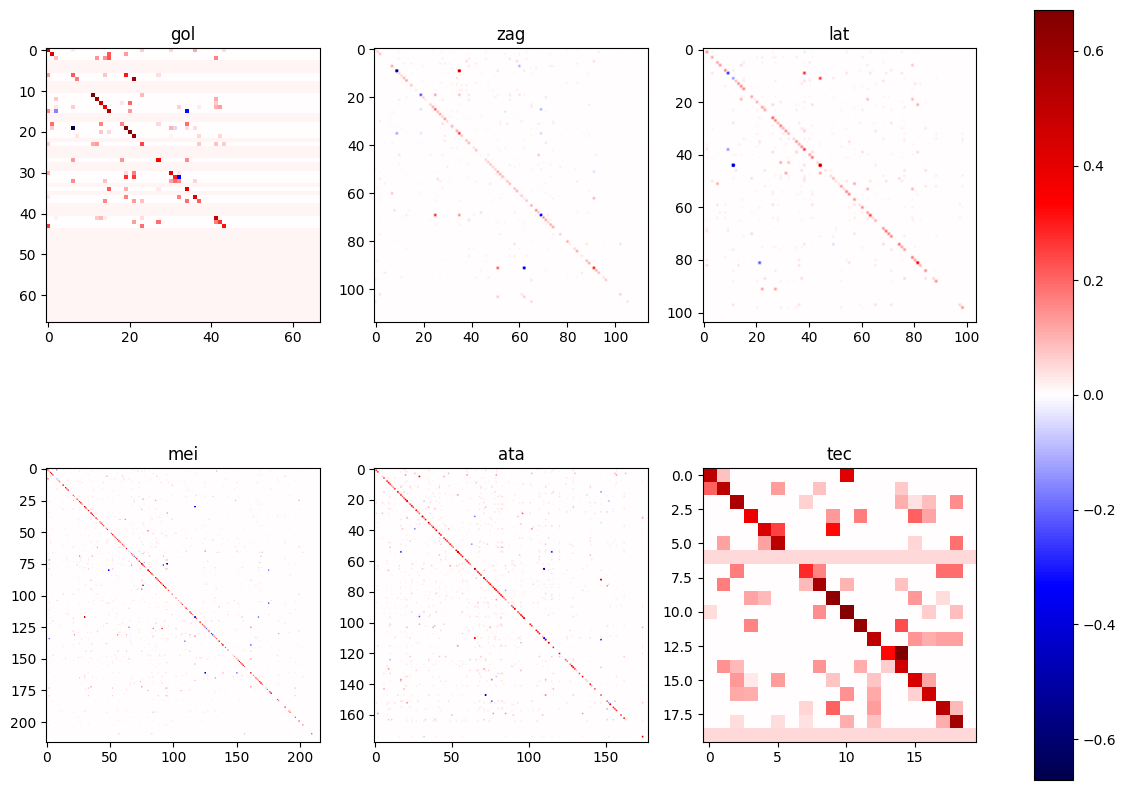

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axesli = axes.flatten()
for i, key in enumerate(out_data):
    im = axesli[i].imshow(out_data[key]["M_norm"], cmap='seismic', norm=TwoSlopeNorm(0))
    axesli[i].set_title(key)

fig.colorbar(im, ax=axes.ravel())


Stationary Distribution plot 

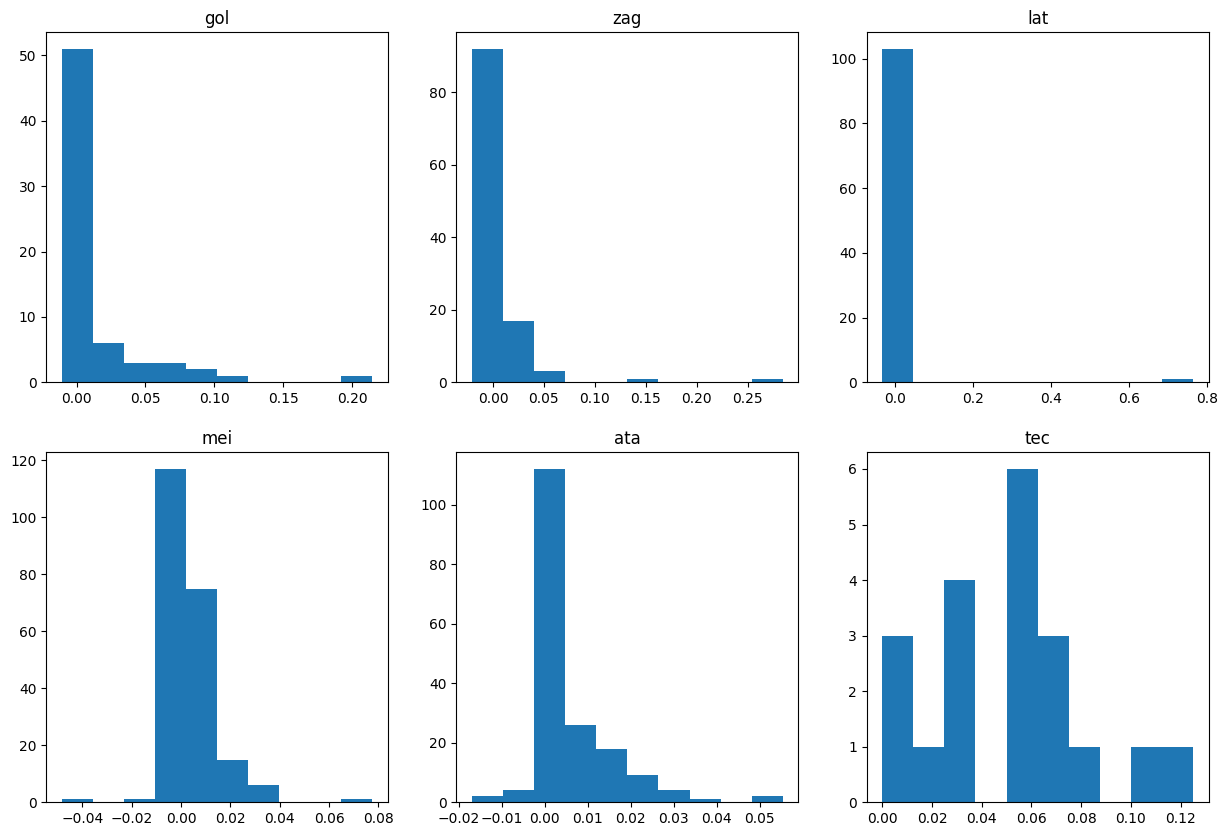

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axesli = axes.flatten()
for i, key in enumerate(out_data):
    im = axesli[i].hist(out_data[key]["st_dist"])
    axesli[i].set_title(key)

### Overperfomance players for each position

In [34]:
position = 'gol'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
5,0.0,Fábio,37656,gol,9.24,FLU,Provável
73,12.0,Marchesín,70332,gol,6.66,GRE,Nulo
82,13.0,Gabriel,70449,gol,3.81,JUV,Provável
94,15.0,Everson,72294,gol,9.62,CAM,Provável
118,19.0,João Ricardo,81881,gol,8.13,FOR,Provável


In [96]:
position = 'zag'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)]

,rank,nickname,id,position,price,team,status
147,25.0,Léo Pereira,83528,zag,7.71,FLA,Contundido
169,29.0,Rodrigo,86684,zag,5.32,CRI,Provável
194,34.0,Igor Rabello,89493,zag,7.32,CAM,Provável
197,35.0,Fabrício Bruno,90768,zag,5.81,FLA,Provável
345,65.0,Kaíque Rocha,103684,zag,8.32,CAP,Provável
367,70.0,Igor Gomes,104385,zag,4.85,INT,Nulo


In [36]:
position = 'lat'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
339,63.0,Matheus Bidu,105531,lat,6.45,COR,Nulo


In [37]:
position = 'mei'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
19,3.0,Everton Ribeiro,51772,mei,9.72,BAH,Provável
81,13.0,Nikão,69705,mei,9.30,CAP,Nulo
91,15.0,Bruno Henrique,70944,mei,6.48,INT,Nulo
128,21.0,Fernandinho,72775,mei,6.86,CAP,Suspenso
142,24.0,Ramiro,78715,mei,3.80,CRU,Nulo


In [38]:
position = 'ata'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
50,8.0,Marinho,68952,ata,4.49,FOR,Contundido
124,20.0,Rafa Silva,80225,ata,6.23,CRU,Provável
126,21.0,Luciano,80287,ata,10.66,SAO,Suspenso
141,24.0,Luiz Araújo,82627,ata,6.99,FLA,Nulo
156,27.0,Tiquinho Soares,84042,ata,14.00,BOT,Provável


In [39]:
position = 'tec'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
3,0.0,Renato Gaúcho,41929,tec,9.28,GRE,Provável
6,1.0,Cuca,42411,tec,11.57,CAP,Provável
17,2.0,Tite,45125,tec,11.07,FLA,Provável
21,3.0,Fernando Diniz,72391,tec,9.78,FLU,Provável
34,5.0,Roger Machado,79437,tec,6.44,JUV,Provável


## Using linear programming to build the team

Adding probabilities in players on the market data

In [41]:
df_players_anl = players_ranked.copy()
df_players_anl['rank'] = df_players_anl['rank'].astype(int)
df_players_anl['prob'] = 0.00

In [42]:
def get_prob(df):
    position = df['position']
    rank = df['rank']
    return out_data.get(position)["st_dist"][int(rank)]

In [43]:
df_players_anl['prob'] = df_players_anl.apply(get_prob, axis=1)

In [44]:
df_players_anl.sort_values('prob', ascending=False).head()

,rank,nickname,id,position,price,team,status,prob
339,63,Matheus Bidu,105531,lat,6.45,COR,Nulo,0.763984
169,29,Rodrigo,86684,zag,5.32,CRI,Provável,0.284473
121,20,Alisson,84266,gol,3.05,CRI,Nulo,0.214818
194,34,Igor Rabello,89493,zag,7.32,CAM,Provável,0.137585
63,10,Rogério Ceni,97341,tec,10.15,BAH,Provável,0.125025


In [71]:
df_players_anl['nickname'] = df_players_anl['nickname'].str.replace(" ", "_")
df_players_likely = df_players_anl[df_players_anl.status == "Provável"]

### Giving extra probability points for the players that will play at home.

I found this [study](https://www.scielo.br/j/rbcdh/a/wc9c38CkYs5NZJYSF6SpNJR/?format=pdf&lang=pt) who says that teams in brazillian championship has 25% more chance to win when playing at home;


In [46]:
next_matches = get_next_match()

In [64]:
home_team = next_matches["home_team"].values

In [65]:
home_team

array(['GRE', 'VIT', 'FLU', 'CUI', 'COR', 'CAM', 'VAS', 'CRI', 'SAO',
       'FOR'], dtype=object)

In [73]:
df_players_likely_bonus = df_players_likely.copy()

In [74]:
df_players_likely_bonus.loc[df_players_likely_bonus.team.isin(home_team), 'prob'] *= 1.25

In [77]:
df_players_likely_bonus.head()

,rank,nickname,id,position,price,team,status,prob
1,0,Thiago_Heleno,38394,zag,6.53,CAP,Provável,0.005032
3,0,Renato_Gaúcho,41929,tec,9.28,GRE,Provável,0.046596
5,0,Fábio,37656,gol,9.24,FLU,Provável,0.092776
6,1,Cuca,42411,tec,11.57,CAP,Provável,0.062602
7,1,Hulk,39148,ata,14.21,CAM,Provável,0.003813


### Optimization

In [47]:
from pulp import LpMaximize, LpProblem, lpSum, LpVariable
import pandas as pd

In [85]:
# Team and money constraints
team = {
    'ata': 3,
    'mei': 3,
    'lat': 2,
    'zag': 2,
    'gol':1,
    'tec':1
}

money = 94.15

In [81]:
# Selecting the dataframe to use in the optimization
df = df_players_likely_bonus.copy()

In [82]:
df.set_index("id", inplace=True)
z = df['prob'].to_dict()
c = df['price'].to_dict()

dummies_position = pd.get_dummies(df.position)
dummies_position = dummies_position.to_dict()
prob = LpProblem("Players CHoice", LpMaximize)
y = LpVariable.dicts("player_id", df.index , 0,1,cat='Binary')
prob += lpSum([z[i] * y[i] for i in y])

/home/jucelio/.local/share/virtualenvs/mkv-cartola-AYh-Mpys/lib/python3.9/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [83]:
prob += lpSum([c[i] * y[i] for i in y]) <= money, "money_limit"
prob += lpSum([dummies_position['ata'][i] * y[i] for i in y]) == team['ata'], "Quantidade Atacantes"
prob += lpSum([dummies_position['lat'][i] * y[i] for i in y]) == team['lat'], "Quantidade Laterais"
prob += lpSum([dummies_position['mei'][i] * y[i] for i in y]) == team['mei'], "Quantidade Meio"
prob += lpSum([dummies_position['zag'][i] * y[i] for i in y]) == team['zag'], "Quantidade Zagueiros"
prob += lpSum([dummies_position['gol'][i] * y[i] for i in y]) == team['gol'], "Quantidade Gol"
prob += lpSum([dummies_position['tec'][i] * y[i] for i in y]) == team['tec'], "Quantidade Tecnico"


In [86]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/jucelio/.local/share/virtualenvs/mkv-cartola-AYh-Mpys/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c7b237aa183344199b4bbe585024e638-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/c7b237aa183344199b4bbe585024e638-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 1138 RHS
At line 1146 BOUNDS
At line 1372 ENDATA
Problem MODEL has 7 rows, 225 columns and 450 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.11809 - 0.01 seconds
Cgl0004I processed model has 7 rows, 222 columns (222 integer (220 of which binary)) and 444 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.279141
Cbc0038I Pass   1: suminf.    0.15799 (2) obj. -1.11793 iterations 5
Cbc0038I Solution found of -1.09591
Cbc0038I Cleaned solution of -1

1

In [87]:
escalados = []
for v in prob.variables():
    if v.varValue == 1:
        atleta = v.name.replace('player_id_','')
        escalados.append(int(atleta))
        print(atleta, "=", v.varValue)

110193 = 1.0
112886 = 1.0
117632 = 1.0
71701 = 1.0
81845 = 1.0
81881 = 1.0
84428 = 1.0
86485 = 1.0
86684 = 1.0
87228 = 1.0
89493 = 1.0
97341 = 1.0


In [91]:
my_team = df.loc[escalados]

In [92]:
my_team

,rank,nickname,position,price,team,status,prob
id,,,,,,,
110193,107,Lázaro,ata,4.78,PAL,Provável,0.019583
112886,113,Lucas_Barbosa,ata,10.00,JUV,Provável,0.055307
117632,168,Garro,mei,7.49,COR,Provável,0.044544
71701,11,Santiago_Arias,lat,6.47,BAH,Provável,0.045686
81845,30,Alisson,mei,6.04,SAO,Provável,0.036424
81881,19,João_Ricardo,gol,8.13,FOR,Provável,0.111155
84428,35,Fernando_Sobral,mei,5.51,CUI,Provável,0.096980
86485,31,Keno,ata,8.16,FLU,Provável,0.028717
86684,29,Rodrigo,zag,5.32,CRI,Provável,0.355591


In [93]:
my_team['price'].sum()

93.37

TODO: 
- ~~Adicionar bonus para o caso do próximo jogo ser em casa;~~
- Adicionar bonus para quem joga contra os últimos da tabela; ou a diferença entre as posições(?)
- Adicionar restrição para que os jogadores escalados não se enfrentem na rodada;
- Adicionar minimização para escolher os melhores reservas;
- Adicionar possibilidade de outras escalações;
- Adicionar método para a escolha do capitão.



## Test sections

In [56]:
from cartolafc import Api

In [57]:
api = Api()

In [58]:
current_round = api.mercado().rodada_atual

In [59]:
matches_current_round = api.partidas(current_round)

In [60]:
matches_current_round[0]

{"data": {"year": 2024, "month": 6, "day": 1, "hour": 16, "minute": 0, "second": 0, "microsecond": 0, "tzinfo": null}, "local": "Couto Pereira", "clube_casa": {"id": 284, "nome": "Gr\u00eamio", "abreviacao": "GRE"}, "placar_casa": null, "clube_visitante": {"id": 280, "nome": "Bragantino", "abreviacao": "BGT"}, "placar_visitante": null}

In [61]:
api.mercado().status

Status(id=1, nome='Mercado aberto')